# Homework07

Exercises to practice pandas, data analysis and regression

## Goals

- Understand the effects of pre-processing data
- Get familiar with the ML flow: encode -> normalize -> train -> evaluate
- Understand the difference between regression and classification tasks
- Build intuition for different regression models

### Setup

Run the following 2 cells to import all necessary libraries and helpers for this homework.

In [15]:
!wget -q https://github.com/PSAM-5020-2025F-A/5020-utils/raw/main/src/data_utils.py

In [16]:
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.linear_model import LinearRegression, SGDRegressor

from data_utils import object_from_json_url
from data_utils import regression_error

### Load Dataset

Let's load up the full [ANSUR](https://www.openlab.psu.edu/ansur2/) dataset that we looked at briefly in [Week 02](https://github.com/DM-GY-9103-2024F-H/WK02).

This is the dataset that has anthropometric information about U.S. Army personnel.

#### WARNING

Like we mentioned in class, this dataset is being used for these exercises due to the level of detail in the dataset and the rigorous process that was used in collecting the data.

This is a very specific dataset and should not be used to draw general conclusions about people, bodies, or anything else that is not related to the distribution of physical features of U.S. Army personnel.

In [17]:
# Load Dataset
ANSUR_FILE = "https://raw.githubusercontent.com/PSAM-5020-2025F-A/5020-utils/main/datasets/json/ansur.json"
ansur_data = object_from_json_url(ANSUR_FILE)

# Look at first 2 records
ansur_data[:2]

[{'age': 18,
  'gender': 'F',
  'height': 66,
  'weight': 135,
  'span': 1699,
  'stature': 1645,
  'ear': {'breadth': 30, 'length': 61, 'protrusion': 20},
  'foot': {'breadth': 97, 'length': 243},
  'hand': {'breadth': 78, 'length': 182, 'palm': 108},
  'head': {'height': 243, 'circumference': 557}},
 {'age': 30,
  'gender': 'M',
  'height': 68,
  'weight': 207,
  'span': 1749,
  'stature': 1715,
  'ear': {'breadth': 35, 'length': 63, 'protrusion': 17},
  'foot': {'breadth': 100, 'length': 252},
  'hand': {'breadth': 87, 'length': 184, 'palm': 114},
  'head': {'height': 238, 'circumference': 560}}]

#### Nested data

This is that *nested* dataset from Week 02.

# 🤔

Let's load it into a `DataFrame` to see what happens.

In [18]:
# Read into DataFrame
ansur_df = pd.DataFrame.from_records(ansur_data)
ansur_df.head()

,age,gender,height,weight,span,stature,ear,foot,hand,head
0,18,F,66,135,1699,1645,"{'breadth': 30, 'length': 61, 'protrusion': 20}","{'breadth': 97, 'length': 243}","{'breadth': 78, 'length': 182, 'palm': 108}","{'height': 243, 'circumference': 557}"
1,30,M,68,207,1749,1715,"{'breadth': 35, 'length': 63, 'protrusion': 17}","{'breadth': 100, 'length': 252}","{'breadth': 87, 'length': 184, 'palm': 114}","{'height': 238, 'circumference': 560}"
2,27,M,67,121,1684,1657,"{'breadth': 36, 'length': 59, 'protrusion': 24}","{'breadth': 92, 'length': 251}","{'breadth': 84, 'length': 180, 'palm': 103}","{'height': 239, 'circumference': 516}"
3,20,M,73,185,1878,1828,"{'breadth': 36, 'length': 60, 'protrusion': 21}","{'breadth': 104, 'length': 280}","{'breadth': 95, 'length': 201, 'palm': 124}","{'height': 270, 'circumference': 582}"
4,33,M,76,150,1977,1883,"{'breadth': 39, 'length': 65, 'protrusion': 27}","{'breadth': 101, 'length': 271}","{'breadth': 90, 'length': 194, 'palm': 113}","{'height': 254, 'circumference': 559}"



# 😓🙄

That didn't work too well. We ended up with objects in our columns.

Luckily, our `DataFrame` library has a function called [`json_normalize()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.json_normalize.html) that can help.

In [19]:
# Read into DataFrame
ansur_df = pd.json_normalize(ansur_data)
ansur_df.head()

,age,gender,height,weight,span,stature,ear.breadth,ear.length,ear.protrusion,foot.breadth,foot.length,hand.breadth,hand.length,hand.palm,head.height,head.circumference
0,18,F,66,135,1699,1645,30,61,20,97,243,78,182,108,243,557
1,30,M,68,207,1749,1715,35,63,17,100,252,87,184,114,238,560
2,27,M,67,121,1684,1657,36,59,24,92,251,84,180,103,239,516
3,20,M,73,185,1878,1828,36,60,21,104,280,95,201,124,270,582
4,33,M,76,150,1977,1883,39,65,27,101,271,90,194,113,254,559


Much better. `DataFrames` are magic.

#### Data Exploration

Before we start creating models, let's do a little bit of data analysis and get a feeling for the shapes, distributions and relationships of our data.

1. Print `min`, `max` and `average` values for all of the features.
2. Print `covariance` tables for `age`, `ear.length` and `head.circumference`.
3. Plot `age`, `ear.length` and `head.circumference` versus the $1$ *feature* that is most correlated to each of them.

Don't forget to *encode* and *normalize* the data.

   age  gender  height  weight  span  stature  ear.breadth  ear.length  \
0   18     0.0      66     135  1699     1645           30          61   
1   30     1.0      68     207  1749     1715           35          63   
2   27     1.0      67     121  1684     1657           36          59   
3   20     1.0      73     185  1878     1828           36          60   
4   33     1.0      76     150  1977     1883           39          65   

   ear.protrusion  foot.breadth  foot.length  hand.breadth  hand.length  \
0              20            97          243            78          182   
1              17           100          252            87          184   
2              24            92          251            84          180   
3              21           104          280            95          201   
4              27           101          271            90          194   

   hand.palm  head.height  head.circumference  
0        108          243                 557  
1       

,age,gender,height,weight,span,stature,ear.breadth,ear.length,ear.protrusion,foot.breadth,foot.length,hand.breadth,hand.length,hand.palm,head.height,head.circumference
age,1.000179,0.062201,0.029467,0.217017,0.064304,0.037972,0.187740,0.292098,-0.009254,0.064993,0.048699,0.133830,0.104642,0.120726,0.038637,0.014044
gender,0.062201,1.000179,0.656634,0.562369,0.648306,0.663334,0.410499,0.463540,0.413054,0.641221,0.669078,0.746050,0.495310,0.508053,0.559495,0.339537
height,0.029467,0.656634,1.000179,0.659590,0.869103,0.959988,0.355310,0.421910,0.283853,0.662081,0.820186,0.712196,0.736264,0.695159,0.554231,0.439234
weight,0.217017,0.562369,0.659590,1.000179,0.662828,0.682587,0.361981,0.487481,0.242281,0.708759,0.688228,0.710663,0.599894,0.591608,0.521809,0.540160
span,0.064304,0.648306,0.869103,0.662828,1.000179,0.899400,0.348283,0.401564,0.268229,0.681016,0.862806,0.731574,0.844382,0.796280,0.536677,0.476903
stature,0.037972,0.663334,0.959988,0.682587,0.899400,1.000179,0.365847,0.438604,0.289324,0.677517,0.844233,0.727613,0.761877,0.720473,0.577022,0.462999
ear.breadth,0.187740,0.410499,0.355310,0.361981,0.348283,0.365847,1.000179,0.454968,0.240675,0.367536,0.385165,0.415684,0.341742,0.293001,0.277395,0.221058
ear.length,0.292098,0.463540,0.421910,0.487481,0.401564,0.438604,0.454968,1.000179,0.382646,0.436241,0.419030,0.465829,0.335176,0.341726,0.384718,0.283878
ear.protrusion,-0.009254,0.413054,0.283853,0.242281,0.268229,0.289324,0.240675,0.382646,1.000179,0.294336,0.279865,0.316847,0.194417,0.204587,0.273468,0.124790
foot.breadth,0.064993,0.641221,0.662081,0.708759,0.681016,0.677517,0.367536,0.436241,0.294336,1.000179,0.759427,0.789143,0.661091,0.639648,0.547463,0.492590


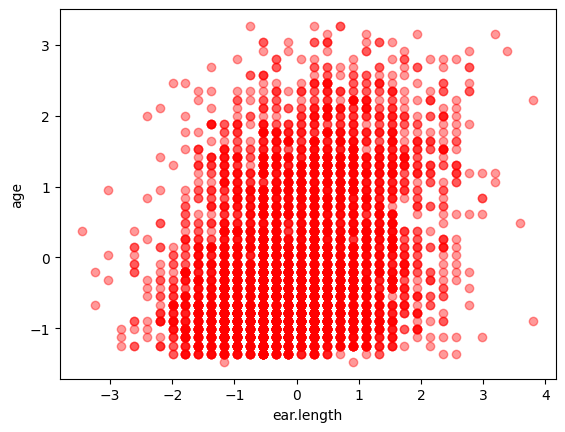

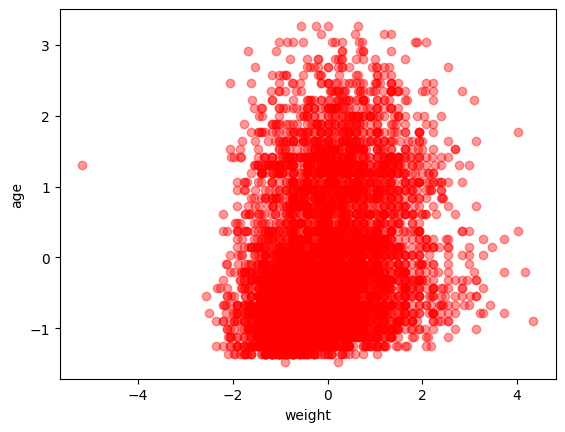

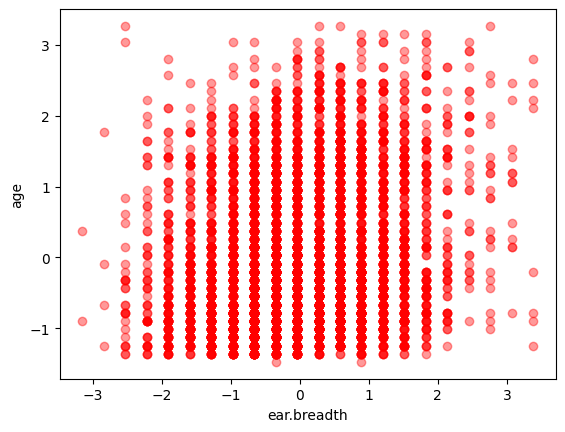

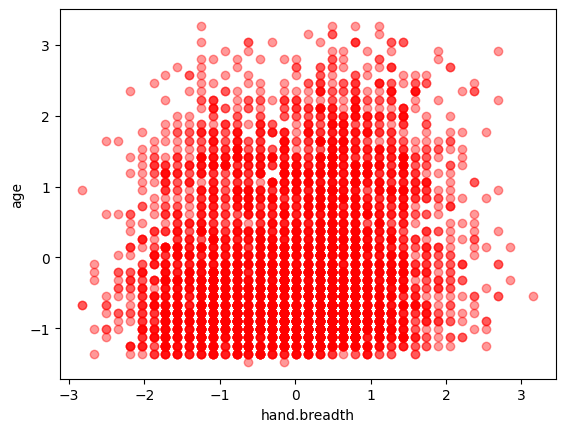

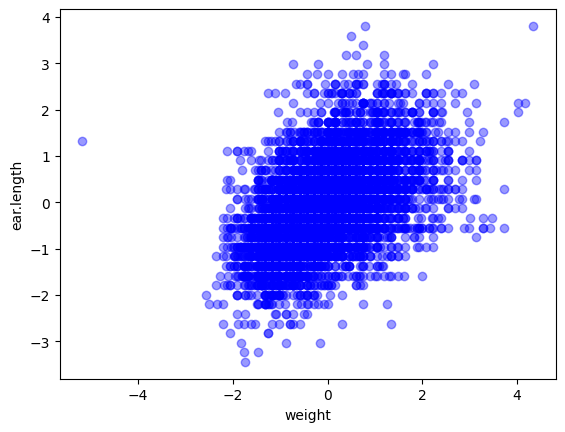

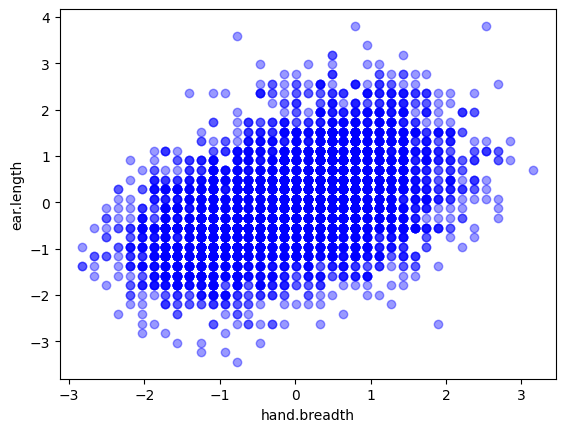

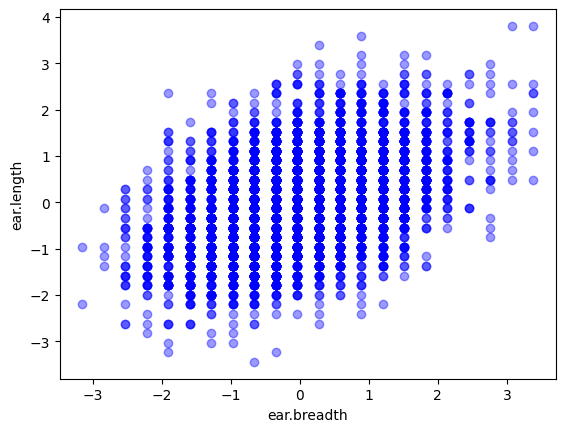

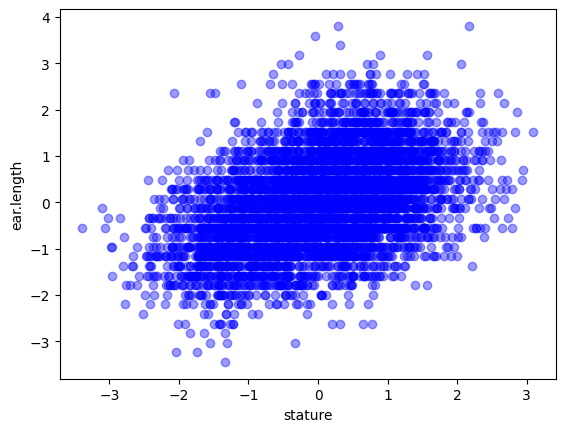

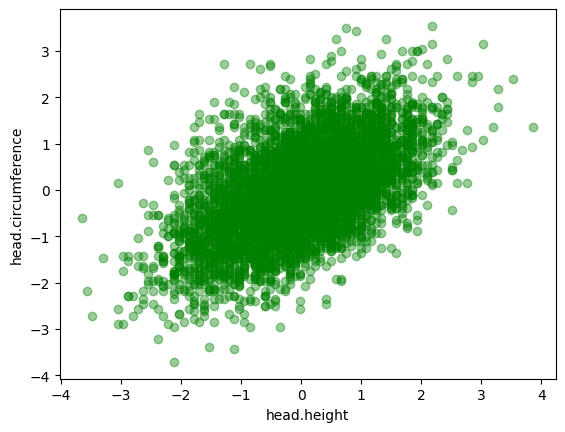

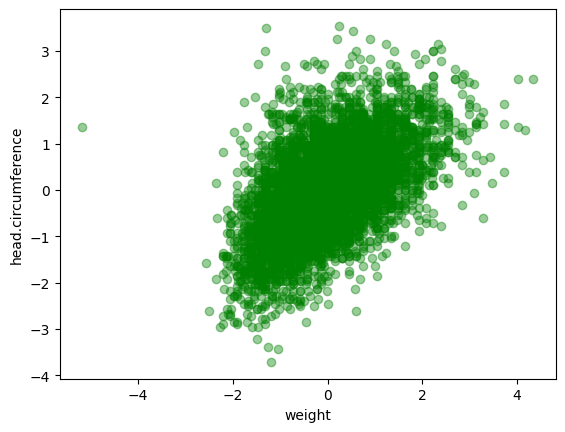

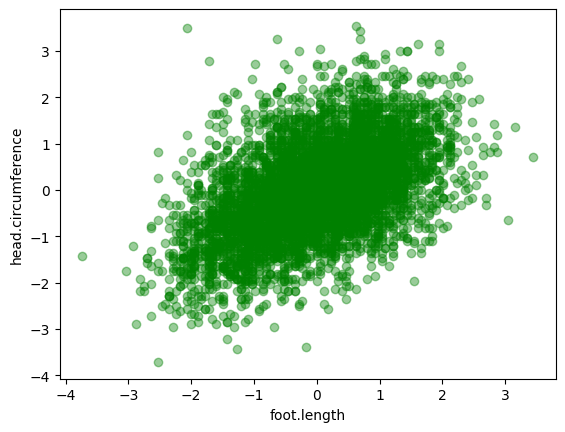

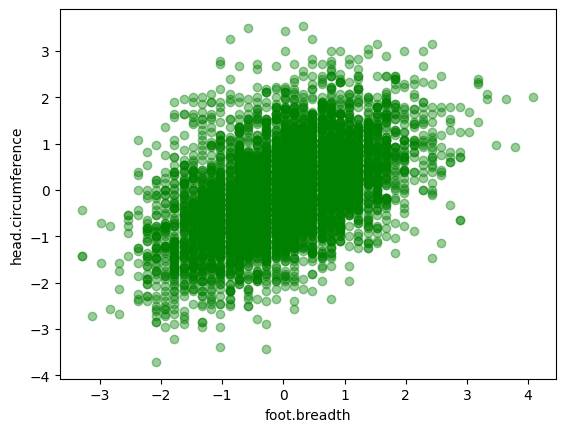

In [20]:
# Work on Data Exploration here

### Encode non-numerical features
# gender is non-numerical and has two possible values: F and M
# since the values don't have an order, we could use OneHotEncoder, which turns each value into a distinct feature and uses 0 and 1 to mark whether a record has a value or not
# but we can also use OrdinalEncoder, which assigns each value a distinct integer
# here, we will use OrdinalEncoder (since it was the imported encoder on cell 2)

# giving the encoder all possible values as an initialization parameter
ansur_encoder = OrdinalEncoder(categories=[['F', 'M']])

# encoding the gender column
ansur_df['gender'] = ansur_encoder.fit_transform(ansur_df[['gender']])

# checking the new dataframe and confirming is has been encoded correctly
print(ansur_df.head())
# 0 = F, 1 = M

# ## 1. Print min, max, avg
max_values = ansur_df.max()
min_values = ansur_df.min()
avg_values = ansur_df.mean()
# print("max values are:\n", max_values)
# print("min values are:\n", min_values)
# print("avg values are:\n", avg_values)

# ### Normalize all data
# using StandardScaler, to represent each data point in terms of the aggregate characteristics for that collection of points
ansur_scaler = StandardScaler().set_output(transform="pandas")
ansur_scaled_df = ansur_scaler.fit_transform(ansur_df)

# ## 2. Print Covariances
display(ansur_scaled_df.cov())

# ## 3. Plot features most correlated to age, ear length and head circumference
# # features most correlated to age are ear.length, weight, ear.breadth, and hand.breadth
# # ear.length has strong correlation with different features: weight, hand.breadth, ear.breadth, stature, etc
# # the same applies to head circumference, with head.height, weight, foot.length	, and foot.breadth being the most correlated features

# plot age as a function of ear.length, weight, ear.breadth, and hand.breadth
for feat in ["ear.length", "weight", "ear.breadth", "hand.breadth"]:
  plt.plot(ansur_scaled_df[feat], ansur_scaled_df["age"], marker="o", color="r", linestyle="", alpha=0.4)
  plt.xlabel(feat)
  plt.ylabel("age")
  plt.show()

# plot ear.length as a function of weight, hand.breadth, ear.breadth, stature
for feat in ["weight", "hand.breadth", "ear.breadth", "stature"]:
  plt.plot(ansur_scaled_df[feat], ansur_scaled_df["ear.length"], marker="o", color="b", linestyle="", alpha=0.4)
  plt.xlabel(feat)
  plt.ylabel("ear.length")
  plt.show()
# these plots show a stronger, more discernible positive correlation between ear.length and the other features

# plot head.circumference as a function of head.height, weight, foot.length, and foot.breadth
for feat in ["head.height", "weight", "foot.length", "foot.breadth"]:
  plt.plot(ansur_scaled_df[feat], ansur_scaled_df["head.circumference"], marker="o", color="g", linestyle="", alpha=0.4)
  plt.xlabel(feat)
  plt.ylabel("head.circumference")
  plt.show()
# these plots also show a strong positive correlation between head.circumference and the other features



### Interpretation

<span style="color:hotpink;">
Does anything stand out about these graphs? Or the correlations?<br>
Are correlations symmetric? Does the feature most correlated to ear length also have ear length as its most correlated pair?
</span>

The plots for age should show a positive correlation between age and the other features, but the correlation is subtle so it's almost visually undiscernible in all cases except for ear.length, which shows a more pronounced positive correlation.

In contrast, the plots for ear.length and head.circumference show a clearer, strong correlation between the variables and the respective correlated features.
Overall, this suggests that age is not a strong predictor of other features, whereas body measures are much strongly intercorrelated.

Correlations are symmetric, meaning that the correlation between variable X and variable Y is identical to the correlation between variable Y and variable X. But this does not mean that the feature most correlated with a variable also has to have that variable as its most correlated pais. For example, the feature with which ear.length has the strongest correlation is weight. But weight shows more correlation with several other values than with ear.length, such as hand.breadth, foot.breadth, foot.length, and stature.

### Regression

Now, we want to create a regression model to predict `head.circumference` from the data.

From our [Week 07](https://github.com/PSAM-5020-2025F-A/WK07) notebook, we can create a regression model by following these steps:

1. Load dataset (done! 🎉)
2. Encode label features as numbers (done! ⚡️)
3. Normalize the data (done! 🍾)
4. Separate the outcome variable and the input features
5. Create a regression model using all features
6. Run model on training data and measure error
7. Plot predictions and interpret results
8. Run model on test data, measure error, plot predictions, interpret results

error on training data: 0.7779232106405695


/tmp/ipykernel_16573/885926163.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


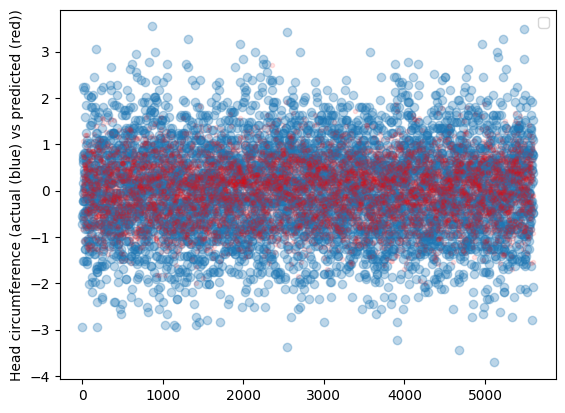

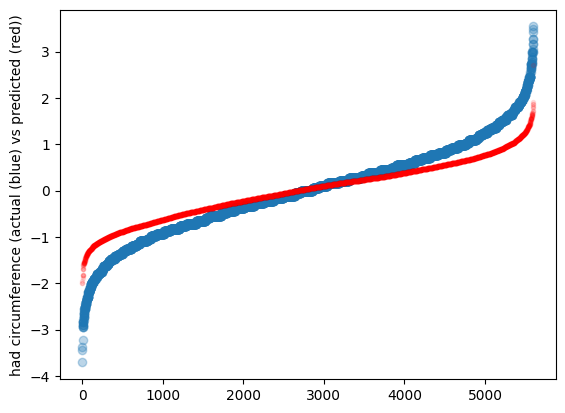

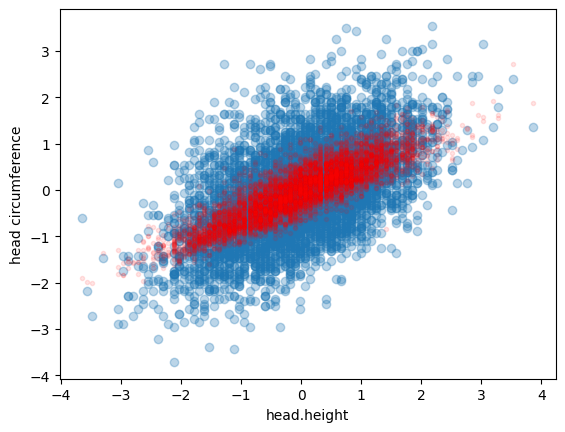

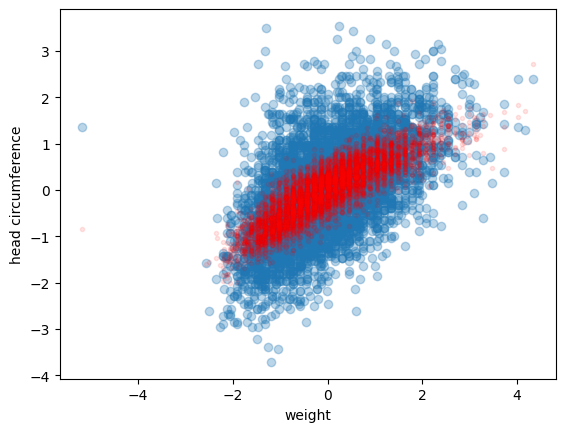

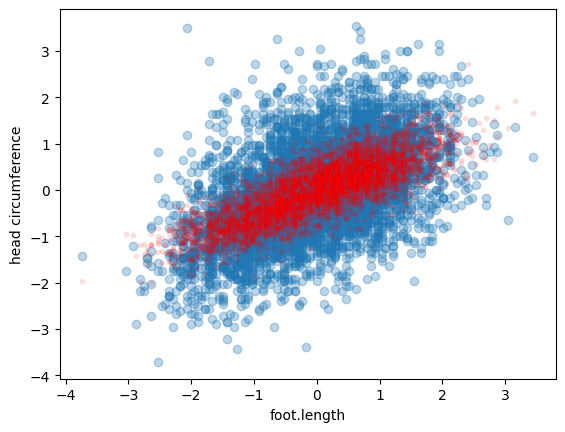

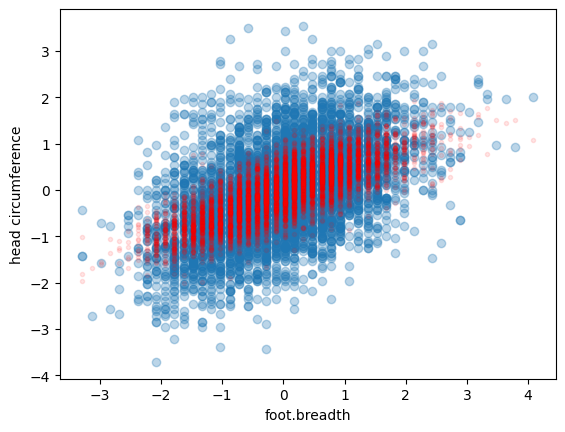

In [ ]:
# Work on Regression Model here

## Separate outcome variable and input features
head_circumference = ansur_scaled_df[["head.circumference"]]
# using only 3 features that are most correlated to head.circumference, so that we can then plot and visualize the results more easily
features = ansur_scaled_df[["head.height", "weight", "foot.length", "foot.breadth"]]

## Create a regression model
head_circumference_model = LinearRegression().fit(features, head_circumference)

## Measure error on training data
predicted_head_circumference = head_circumference_model.predict(features)
error = regression_error(head_circumference, predicted_head_circumference)
print("error on training data:", error)

## Plot predictions and interpret results

# plotting actual vs predicted head circumference values, one over the other
plt.plot(head_circumference, marker='o', linestyle='', alpha=0.3)
plt.plot(predicted_head_circumference, color='r', marker='o', markersize='3', linestyle='', alpha=0.1)
plt.ylabel("Head circumference")
plt.legend()
plt.show()
# we can see that the model is able to capture the overall trend of head circumference values, but there is a significant amount of error in the predictions,
# seen by the vertical distance between the blue and red points

# another way to visualize how far off the model is from the actual data is to look at sorted lists of head circumferences
# this lets us see if there are ranges where the model is wrong/right more often
plt.plot(sorted(head_circumference.values), marker='o', linestyle='', alpha=0.3)
plt.plot(sorted(predicted_head_circumference), color='r', marker='o', markersize='3', linestyle='', alpha=0.1)
plt.ylabel("had circumference (actual (blue) vs predicted (red))")
plt.show()
# we can see that there is a larger divergence between actual and predicted values at the extreme ends of the head circumference values than at the middle ranges


# and since there are more than 3 variables to map, we can just plot head circumference as a function of a few individual features
# plot head.circumference vs head.height, weight, foot.length, foot.breadth
for feat in ["head.height", "weight", "foot.length", "foot.breadth"]:
  x = ansur_scaled_df[feat]
  head_circumference_original = ansur_scaled_df["head.circumference"]
  head_circumference_predicted = predicted_head_circumference
  # Plot the original and predicted head circumferences
  plt.plot(x, head_circumference_original, marker='o', linestyle='', alpha=0.3)
  plt.plot(x, head_circumference_predicted, color='r', marker='o', markersize='3', linestyle='', alpha=0.1)
  plt.xlabel(feat)
  plt.ylabel("head circumference")
  plt.show()

# overall, the scatterplots show that that the predicted trend is correct, seen in the linear relationship between predicted and actual values. 
# But there is a large error margin in the predictions--even more pronounced at the extreme ends of the head circumference values

In [24]:
## Load Test Data
ANSUR_TEST_FILE = "https://raw.githubusercontent.com/PSAM-5020-2025F-A/5020-utils/main/datasets/json/ansur-test.json"

ansur_test_data = object_from_json_url(ANSUR_TEST_FILE)
ansur_test_df = pd.json_normalize(ansur_test_data)

ansur_test_encoded_df = ansur_test_df.copy()

g_vals = ansur_encoder.transform(ansur_test_df[["gender"]].values)
ansur_test_encoded_df[["gender"]] = g_vals

ansur_test_scaled_df = ansur_scaler.transform(ansur_test_encoded_df)

error on test data: 0.8042548497621995


/tmp/ipykernel_16573/2567935365.py:19: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


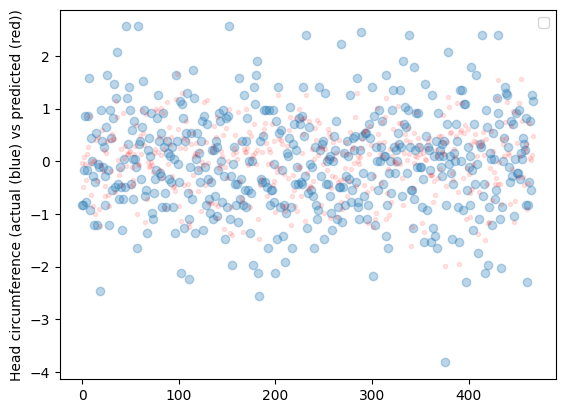

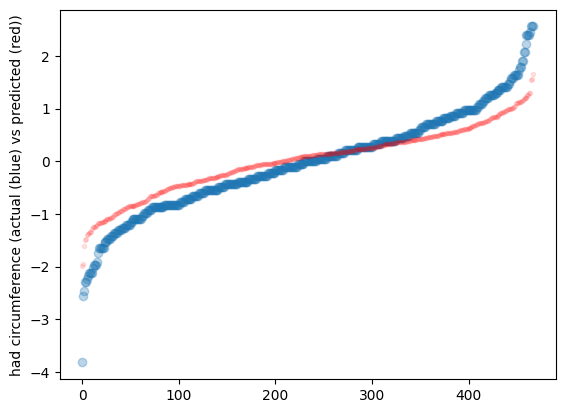

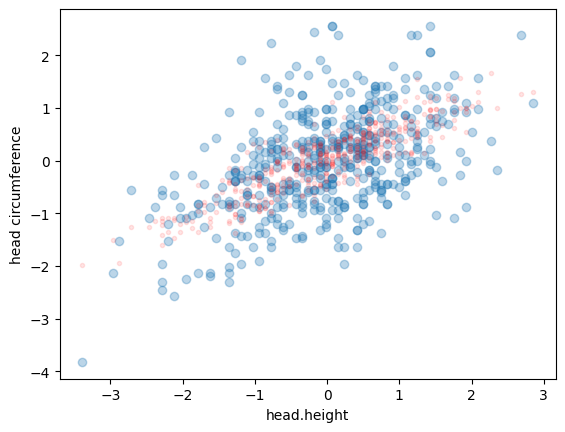

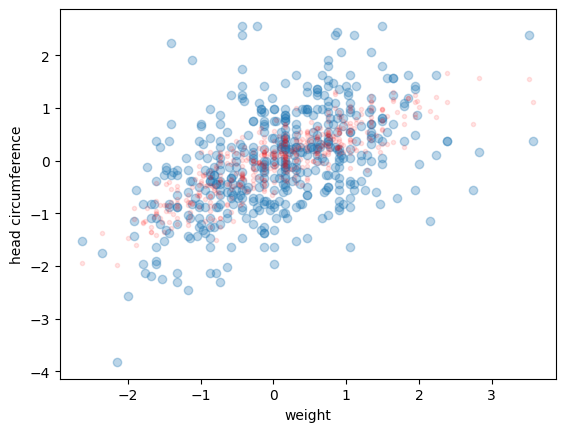

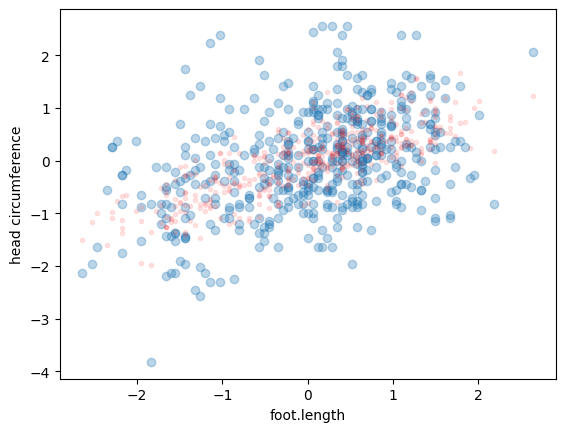

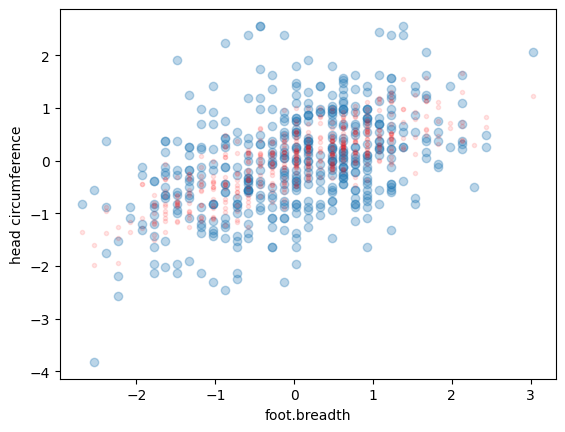

In [25]:
## Run model on test data

## Separate outcome variable and input features
head_circumference_test = ansur_test_scaled_df[["head.circumference"]]
# using only 3 features that are most correlated to head.circumference, so that we can then plot and visualize the results more easily
features_test = ansur_test_scaled_df[["head.height", "weight", "foot.length", "foot.breadth"]]


## measuring error on test data with the model created from training data
predicted_head_circumference_test = head_circumference_model.predict(features_test)
error = regression_error(head_circumference_test, predicted_head_circumference_test)
print("error on test data:", error)

## Plot predictions and interpret results

plt.plot(head_circumference_test, marker='o', linestyle='', alpha=0.3)
plt.plot(predicted_head_circumference_test, color='r', marker='o', markersize='3', linestyle='', alpha=0.1)
plt.ylabel("Head circumference (actual (blue) vs predicted (red))")
plt.legend()
plt.show()

# another way to visualize how far off the model is from the actual data is to look at sorted lists of head circumferences
# this lets us see if there are ranges where the model is wrong/right more often
plt.plot(sorted(head_circumference_test.values), marker='o', linestyle='', alpha=0.3)
plt.plot(sorted(predicted_head_circumference_test), color='r', marker='o', markersize='3', linestyle='', alpha=0.1)
plt.ylabel("had circumference (actual (blue) vs predicted (red))")
plt.show()

# and since there are more than 3 variables to map, we can just plot head circumference as a function of a few individual features
# plot head.circumference vs head.height, weight, foot.length, foot.breadth
for feat in ["head.height", "weight", "foot.length", "foot.breadth"]:
  x = ansur_test_scaled_df[feat]
  head_circumference_predicted = predicted_head_circumference_test
  # Plot the original and predicted head circumferences
  plt.plot(x, head_circumference_test, marker='o', linestyle='', alpha=0.3)
  plt.plot(x, head_circumference_predicted, color='r', marker='o', markersize='3', linestyle='', alpha=0.1)
  plt.xlabel(feat)
  plt.ylabel("head circumference")
  plt.show()

### Interpretation

<span style="color:hotpink;">
How well does your model perform?<br>
How could you improve it?<br>
Are there ranges of circumferences that don't get predicted well?
</span>

The model performs reasonably well, in the sense that it captures the overall linear relationship between head circumference and the selected body measures. The training error (~0.78) and test error (~0.80) are close, suggesting that the model generalizes well for unlabeled data and is not overfitted, but those generalization but also indicating that the model doesn’t fully capture all variation. The errors are larger at the extremes of the head-circumference ranges than at the middle ranges. The model could be improved by adding additional correlated features or by allowing for polynomial features.